# Deep Dynamic Network

## Define model and function to add noise to input

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [ ]:
# Check if TensorFlow detects a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Function to generate random noise
def generate_noise(num_noise_inputs):
    return np.random.rand(num_noise_inputs)  # Random values between 0 and 1 for noise

# Define the Frozen Lake environment
states = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
num_states = len(states)
num_actions = 4

# Define the transition matrix
R = np.array([
    ['A', 'E', 'B', 'A'],
    ['B', 'F', 'C', 'A'],
    ['C', 'G', 'D', 'B'],
    ['D', 'H', 'D', 'C'],
    ['A', 'I', 'F', 'E'],
    ['B', 'J', 'G', 'E'],
    ['C', 'K', 'H', 'F'],
    ['D', 'L', 'H', 'G'],
    ['E', 'M', 'J', 'I'],
    ['F', 'N', 'K', 'I'],
    ['G', 'O', 'L', 'J'],
    ['H', 'P', 'L', 'K'],
    ['I', 'M', 'N', 'M'],
    ['J', 'N', 'O', 'M'],
    ['K', 'O', 'P', 'N'],
    ['L', 'P', 'P', 'O']
])
listOfHoles = np.array(['F', 'H', 'L', 'M'])

# Convert states to one-hot encoded vectors, ie: state A: (1, 0, 0, 0, 0, ... 0)
def state_to_one_hot(state):
    one_hot = np.zeros(num_states)
    one_hot[states.index(state)] = 1
    return one_hot

In [ ]:
# Define the number of noise inputs
num_noise_inputs = 10  # 10 additional noise inputs
total_inputs = num_states + num_noise_inputs  # Total input size (original inputs + noise)

# Define the model that accepts both state input and noise input
model = tf.keras.Sequential([
    layers.Input(shape=(total_inputs,)),  # Input size is 26 (16 original + 10 random)
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

## Trained model with noisy input

In [ ]:
import time  # Import the time module

In [ ]:
# Hyperparameters
gamma = 0.9
epsilon = 0.9
evaluation_interval = 2  # Evaluate every iterations

In [ ]:
def evaluate_vin_policy_with_noise(vin_model, noise_size=10, epsilon=0.9, max_steps=100):
    total_reward = 0
    time_steps = 0
    current_state = states[0]  # Start from the initial state

    while time_steps < max_steps:
        state_index = states.index(current_state)
        state_vector = state_to_one_hot(current_state)

        # Generate and append noise to the state vector
        noise_vector = generate_noise(noise_size)
        noisy_state_vector = np.concatenate([state_vector, noise_vector])

        # Predict the values for all possible actions with noise added
        action_values = []

        # Choose an action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            # Exploration: Choose a random action
            best_action = np.random.randint(0, len(R[state_index]))
        else:
          for action in range(len(R[state_index])):
            next_state = R[state_index][action]

            # Generate noise for the next state and append
            next_noise_vector = generate_noise(noise_size)
            next_state_vector = np.concatenate([state_to_one_hot(next_state), next_noise_vector])
            # Predict the value of the next state using the VIN model
            next_state_value = vin_model.predict(next_state_vector.reshape(1, -1))[0][0]
            action_values.append(next_state_value)

          # Exploitation: Choose the best action based on predicted values
          best_action = np.argmax(action_values)

        # Update the current state and calculate reward
        next_state = R[state_index][best_action]
        reward = 0
        if next_state == 'P':
            reward = 1
        elif next_state in listOfHoles:
            reward = -10

        total_reward += reward
        time_steps += 1

        # Check if we've reached a terminal state
        if next_state == 'P':
            break

        # Update current state
        current_state = next_state

    return total_reward, time_steps


In [ ]:
import time
import numpy as np

# Store reward history for plotting or analysis
reward_history = []
time_steps_history = []

#start_time = time.time()  # Record the start time

import numpy as np
import random

# Training loop with evaluation every iterations
for iteration in range(200):
    for state in states:
        state_index = states.index(state)
        state_vector = state_to_one_hot(state)

        # Generate random noise and concatenate to the state vector
        noise_vector = generate_noise(num_noise_inputs)
        noisy_state_vector = np.concatenate([state_vector, noise_vector])

        # Next state vectors for all actions with noise
        next_state_vectors = np.array([
            np.concatenate([state_to_one_hot(R[state_index][a]), generate_noise(num_noise_inputs)])
            for a in range(num_actions)
        ])

        # Predict the values of all possible next states (with noisy inputs)
        next_state_values = model.predict(next_state_vectors)

        # Calculate the target value using the Bellman equation
        target_value = -float('inf')
        for a in range(num_actions):
            next_state = R[state_index][a]

            # Reward calculation
            reward = 0
            if state == 'P':
                reward = 1
            if state in listOfHoles:
                reward = -10

            # Calculate the target value for each action
            value = reward + gamma * next_state_values[a]
            target_value = max(target_value, value)

        # Train the model to output the target value for the current state (with noisy input)
        model.fit(noisy_state_vector.reshape(1, -1), np.array([target_value]), epochs=1, verbose=0)

    # Evaluate the policy every few iterations
    if iteration % evaluation_interval == 0:
      policy_reward, policy_time_steps = evaluate_vin_policy_with_noise(model, noise_size=num_noise_inputs, epsilon=epsilon)
      reward_history.append(policy_reward)
      time_steps_history.append(policy_time_steps)  # Store the time steps for this evaluation
      #print(f"Iteration {iteration}: Evaluated reward = {policy_reward}, Time steps = {policy_time_steps}")

      epsilon = max(0.01, epsilon * 0.995)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

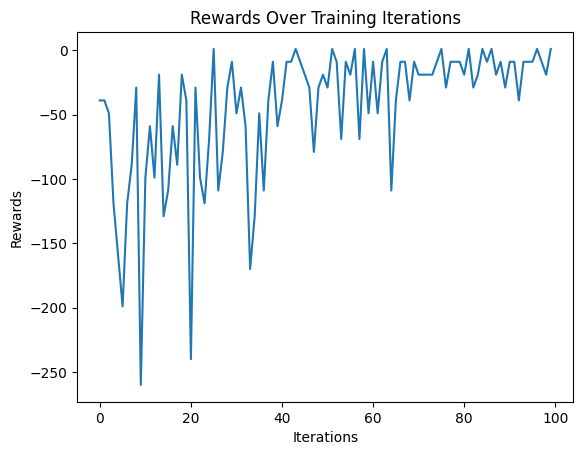

In [ ]:
import matplotlib.pyplot as plt

# Assume reward_history contains the rewards at intervals
evaluation_intervals = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(reward_history)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

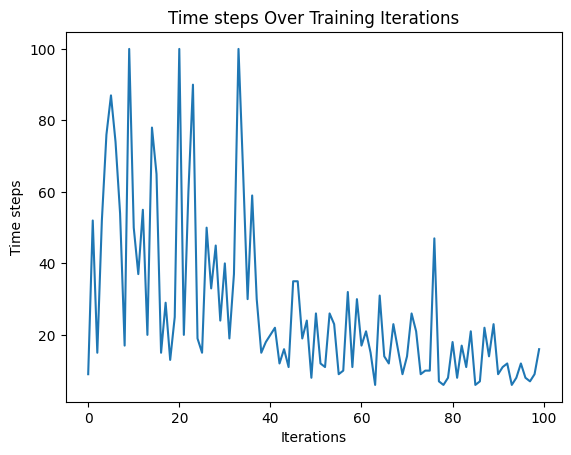

In [ ]:
# Assume reward_history contains the rewards at intervals
evaluation_intervals2 = range(0, 100, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(time_steps_history)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Time steps')
plt.title('Time steps Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# After training, print out the state values for all states
print("\nFinal State Values After Training:")
for state in states:
    state_vector = state_to_one_hot(state)
    noise_vector = np.random.random(10)  # Add the same 10-dimensional noise vector
    noisy_state_vector = np.concatenate([state_vector, noise_vector])

    # Predict the value for the noisy state
    state_value = model.predict(noisy_state_vector.reshape(1, -1), verbose=0)

    print(f"State: {state}, Value: {state_value[0][0]}")


Final State Values After Training:
State: A, Value: 6.0078444480896
State: B, Value: 6.256640434265137
State: C, Value: 7.09796667098999
State: D, Value: 6.136624336242676
State: E, Value: 6.03603458404541
State: F, Value: -2.7552127838134766
State: G, Value: 8.058126449584961
State: H, Value: -3.200981616973877
State: I, Value: 7.252870559692383
State: J, Value: 7.861396312713623
State: K, Value: 8.836716651916504
State: L, Value: -0.18599052727222443
State: M, Value: -2.093048572540283
State: N, Value: 8.885063171386719
State: O, Value: 9.731609344482422
State: P, Value: 10.778192520141602


## Testing


In [ ]:
e = 0.9
reward_history_test = []
time_steps_history_test = []
for iteration in range(200):
  policy_reward, policy_time_steps = evaluate_vin_policy_with_noise(model, noise_size=num_noise_inputs, epsilon=e)
  reward_history_test.append(policy_reward)
  time_steps_history_test.append(policy_time_steps)  # Store the time steps for this evaluation
  print(f"Iteration {iteration}: Evaluated reward = {policy_reward}, Time steps = {policy_time_steps}")

  e = max(0.01, e * 0.995)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Iteration 0: Evaluated reward = -99, Time steps = 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Iteration 1: Evaluated reward = -99, Time steps = 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━

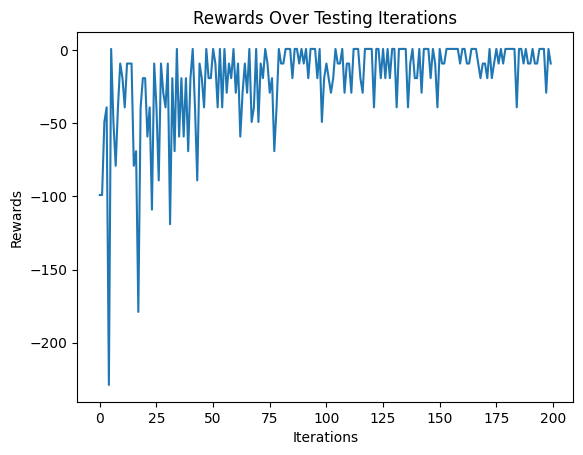

In [ ]:
import matplotlib.pyplot as plt

# Assume reward_history contains the rewards at intervals
evaluation_intervals = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(reward_history_test)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Testing Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

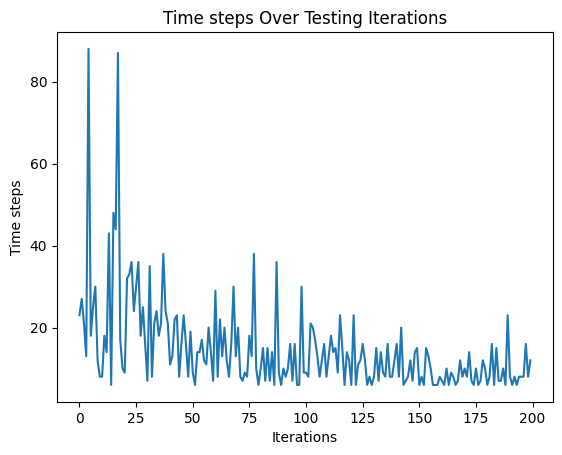

In [ ]:
# Assume reward_history contains the rewards at intervals
evaluation_intervals2 = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(time_steps_history_test)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Time steps')
plt.title('Time steps Over Testing Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

# Reduced Network: Use the activations of the first hidden layer as input

In [ ]:
# Step 1: Freeze the layers of the original model
for layer in model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer.name)

dense
dense_1
dense_2
dense_3


In [ ]:
# Assuming your original model structure is something like this:
#input_layer = layers.Input(shape=(total_inputs,))
first_hidden_layer_output = model.get_layer('dense').output

# Create the feature extraction model

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=first_hidden_layer_output)
# Create dummy data
dummy_input = np.random.random((1, 26))

# Predict features using the feature extractor
try:
    features = feature_extractor.predict(dummy_input)
    print("Feature extraction successful. Output shape:", features.shape)
except Exception as e:
    print("Error during feature extraction:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Feature extraction successful. Output shape: (1, 32)


In [ ]:
# Extract features for each state after training
state_features_dict = {}
print("\nExtracted Features for Each State:")

for state in states:
    # One-hot encode the state and add noise
    state_vector = state_to_one_hot(state)
    noise_vector = np.random.random(10)
    noisy_state_vector = np.concatenate([state_vector, noise_vector])

    # Use the feature extractor model to get the features
    extracted_features = feature_extractor.predict(noisy_state_vector.reshape(1, -1), verbose=0)
    state_features_dict[state] = extracted_features.reshape(-1)

    #print(f"State: {state}, Extracted Features:\n {extracted_features}")


Extracted Features for Each State:


In [ ]:
# convert to 0 & 1
for state, features in state_features_dict.items():
    state_features_dict[state] = np.where(features > 0, 1, 0)

In [ ]:
for state in states:
    print(state_features_dict[state])

[1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1]
[1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0]
[1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0]
[1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1]
[1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0]
[1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0]
[1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1]
[1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1]
[1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0]
[1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 0]
[1 1 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0]
[1 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1]
[1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1]
[1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0]
[1 0 1 0 0

# A reduced sequential model with 2 hidden layer of 32

In [ ]:
# Define a new model using the extracted features
new_model_3 = tf.keras.Sequential([
    layers.Input(shape=(32,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

new_model_3.compile(optimizer='adam', loss='mse')

In [ ]:
def evaluate_vin_policy_with_noise_fe(vin_model, noise_size=10, epsilon=0.9, max_steps=100):
    total_reward = 0
    time_steps = 0
    current_state = states[0]  # Start from the initial state

    while time_steps < max_steps:
        state_index = states.index(current_state)
        #state_features = state_features_dict[state].reshape(1, -1)  # Ensure correct shape

        # Predict the values for all possible actions with noise added
        #action_values = []

        # Generate features for all possible next states based on actions
        next_state_features = np.array([state_features_dict[R[state_index][a]].reshape(1, -1) for a in range(num_actions)])
        next_state_features = np.vstack(next_state_features)  # Stack to shape (num_actions, feature_size)

        # Choose an action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            # Exploration: Choose a random action
            best_action = np.random.randint(0, len(R[state_index]))
        else:
            # Exploitation: Choose the best action based on predicted values
            # Calculate the action value
            next_state_values = vin_model.predict(next_state_features)
            best_action = np.argmax(next_state_values)

        # Update the current state and calculate reward
        next_state = R[state_index][best_action]

        # Calculate reward
        reward = 0
        if next_state == 'P':
            reward = 1
        elif next_state in listOfHoles:
            reward = -10

        total_reward += reward
        time_steps += 1

        # Check if we've reached a terminal state
        if next_state == 'P':
            break

        # Update current state
        current_state = next_state

    return total_reward, time_steps


In [ ]:
# Training loop
# Store reward history for plotting or analysis
reward_history2 = []
start_time2 = time.time()  # Record the start time

# Initial parameters
e = 0.9  # Starting value for epsilon
epsilon_decay = 0.995  # Decay rate for epsilon
min_epsilon = 0.01  # Minimum value for epsilon to avoid full exploitation

time_steps_history2 = []

for iteration in range(200):
    for state in states:
        state_index = states.index(state)
        state_features = state_features_dict[state].reshape(1, -1)  # Ensure correct shape

        # Predict the values of all possible next states
        next_state_features = np.array([state_features_dict[R[state_index][a]].reshape(1, -1) for a in range(num_actions)])
        next_state_features = np.vstack(next_state_features)  # Stack to shape (num_actions, 32)

        next_state_values = new_model_3.predict(next_state_features)

        # Calculate the target value using the Bellman equation
        target_value = -float('inf')
        for a in range(num_actions):
            next_state = R[state_index][a]

            # Reward calculation
            reward = 0
            if state == 'P':
                reward = 1
            if state in listOfHoles:
                reward = -10

            # Calculate the target value for each action
            value = reward + gamma * next_state_values[a]
            target_value = max(target_value, value)

        # Train the new model to output target value for the current state
        new_model_3.fit(state_features, np.array([target_value]), epochs=1, verbose=0)

        # Evaluate the policy every 2 iterations
    if iteration % evaluation_interval == 0:
        # Evaluate the policy with the current epsilon
        policy_reward2, policy_time_steps2 = evaluate_vin_policy_with_noise_fe(new_model_3, noise_size=num_noise_inputs, epsilon=e)

        # Record the reward and time steps
        reward_history2.append(policy_reward2)
        time_steps_history2.append(policy_time_steps2)

        # Decay epsilon, ensuring it doesn't go below the min_epsilon
        e = max(min_epsilon, e * epsilon_decay)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

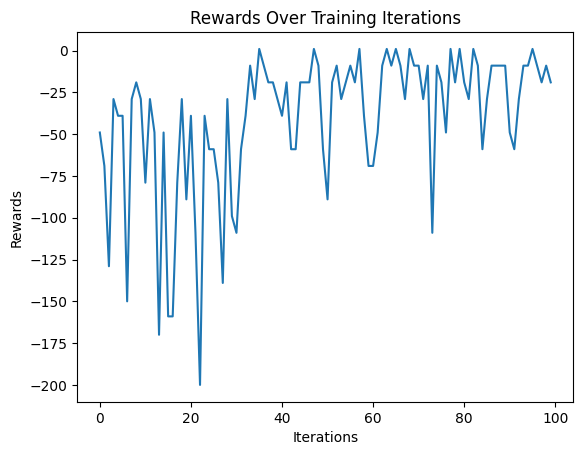

In [ ]:
# Plot the rewards over the training iterations
plt.plot(reward_history2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

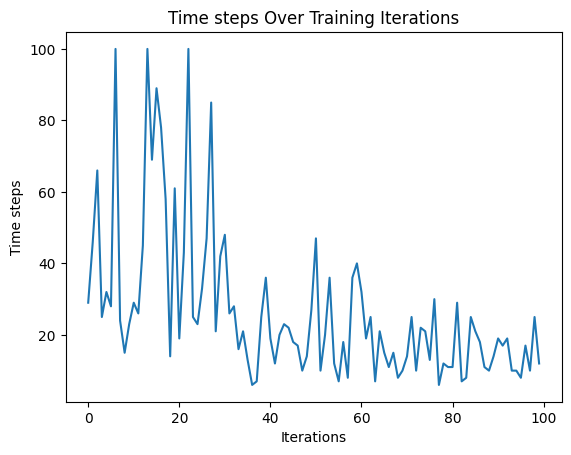

In [ ]:
# Plot the rewards over the training iterations
plt.plot(time_steps_history2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Time steps')
plt.title('Time steps Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

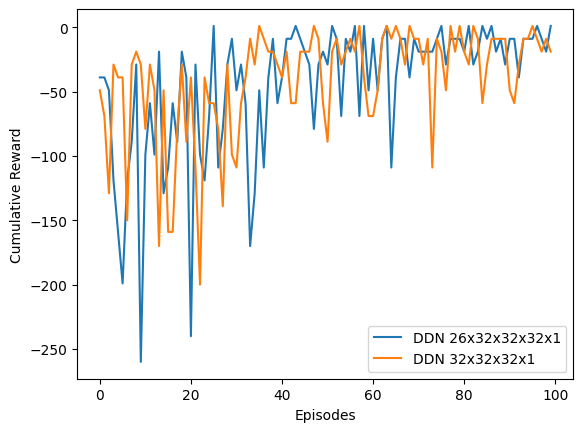

In [ ]:
# Plot the comparison
plt.plot(reward_history, label='DDN 26x32x32x32x1')
plt.plot(reward_history2, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Reward')
#plt.title('Deep Dynamic Network vs Feature Extraction Network Performance (With Noise)')
plt.legend()
plt.show()

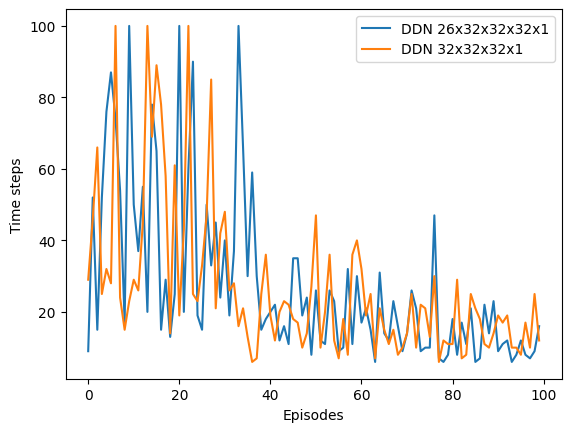

In [ ]:
# Plot the comparison
plt.plot(time_steps_history, label='DDN 26x32x32x32x1')
plt.plot(time_steps_history2, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Time steps')
#plt.title('Deep Dynamic Network vs Feature Extraction Network Performance (With Noise)')
plt.legend()
plt.show()

In [ ]:
# Predict V values for all states
v_values = {}
for state, features in state_features_dict.items():
    features_reshaped = features.reshape(1, -1)  # Ensure correct shape
    v_value = new_model_3.predict(features_reshaped)
    v_values[state] = v_value[0][0]  # Extract the scalar value

# Print V values for each state
for state in states:
    print(f"State: {state}, V-value: {v_values[state]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
State: A, V-value: 5.301912307739258
State: B, V-value: 5.889888763427734
State: C, V-value: 6.545415878295898
State: D, V-value: 5.889632701873779
State: E, V-value: 5.891341209411621
State: F, V-value: -3.4558606147766113
State: G, V-value: 7.271696090698242
State: H, V-value: -3.4574196338653564
State: I, V-value: 6.535435676574707
State: J, V-value: 7.27136754989624
State: K, V-value: 

## Testing


In [ ]:
e = 0.9
reward_history_test2 = []
time_steps_history_test2 = []
for iteration in range(200):
  policy_reward, policy_time_steps = evaluate_vin_policy_with_noise_fe(new_model_3, noise_size=num_noise_inputs, epsilon=e)
  reward_history_test2.append(policy_reward)
  time_steps_history_test2.append(policy_time_steps)  # Store the time steps for this evaluation
  #print(f"Iteration {iteration}: Evaluated reward = {policy_reward}, Time steps = {policy_time_steps}")

  e = max(0.01, e * 0.995)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

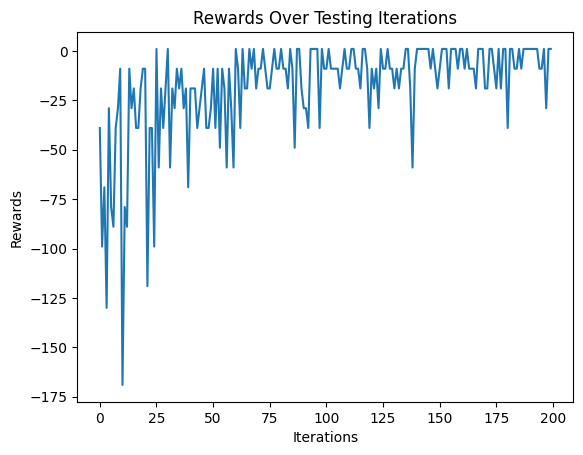

In [ ]:
import matplotlib.pyplot as plt

# Assume reward_history contains the rewards at intervals
evaluation_intervals = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(reward_history_test2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Testing Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

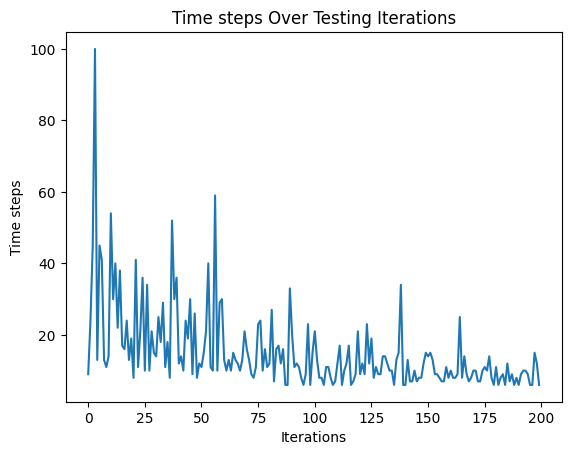

In [ ]:
# Assume reward_history contains the rewards at intervals
evaluation_intervals2 = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(time_steps_history_test2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Time steps')
plt.title('Time steps Over Testing Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Print out each reward for both
print("Rewards collected during evaluation for original:")

for i, reward in enumerate(reward_history):
    print(f"Evaluation {i + 1}: Reward = {reward}")

print("\n")
print("\n")

print("Rewards collected during evaluation for feature extraction:")
for i, reward in enumerate(reward_history2):
    print(f"Evaluation {i + 1}: Reward = {reward}")

Rewards collected during evaluation for original:
Evaluation 1: Reward = -39
Evaluation 2: Reward = -39
Evaluation 3: Reward = -49
Evaluation 4: Reward = -119
Evaluation 5: Reward = -159
Evaluation 6: Reward = -199
Evaluation 7: Reward = -119
Evaluation 8: Reward = -89
Evaluation 9: Reward = -29
Evaluation 10: Reward = -260
Evaluation 11: Reward = -99
Evaluation 12: Reward = -59
Evaluation 13: Reward = -99
Evaluation 14: Reward = -19
Evaluation 15: Reward = -129
Evaluation 16: Reward = -109
Evaluation 17: Reward = -59
Evaluation 18: Reward = -89
Evaluation 19: Reward = -19
Evaluation 20: Reward = -39
Evaluation 21: Reward = -240
Evaluation 22: Reward = -29
Evaluation 23: Reward = -99
Evaluation 24: Reward = -119
Evaluation 25: Reward = -69
Evaluation 26: Reward = 1
Evaluation 27: Reward = -109
Evaluation 28: Reward = -79
Evaluation 29: Reward = -29
Evaluation 30: Reward = -9
Evaluation 31: Reward = -49
Evaluation 32: Reward = -29
Evaluation 33: Reward = -59
Evaluation 34: Reward = -170

In [ ]:
# Print out each reward for both
print("Time step collected during evaluation for original:")

for i, reward in enumerate(time_steps_history):
    print(f"Evaluation {i + 1}: Time step = {reward}")

Time step collected during evaluation for original:
Evaluation 1: Time step = 9
Evaluation 2: Time step = 52
Evaluation 3: Time step = 15
Evaluation 4: Time step = 52
Evaluation 5: Time step = 76
Evaluation 6: Time step = 87
Evaluation 7: Time step = 74
Evaluation 8: Time step = 54
Evaluation 9: Time step = 17
Evaluation 10: Time step = 100
Evaluation 11: Time step = 50
Evaluation 12: Time step = 37
Evaluation 13: Time step = 55
Evaluation 14: Time step = 20
Evaluation 15: Time step = 78
Evaluation 16: Time step = 65
Evaluation 17: Time step = 15
Evaluation 18: Time step = 29
Evaluation 19: Time step = 13
Evaluation 20: Time step = 25
Evaluation 21: Time step = 100
Evaluation 22: Time step = 20
Evaluation 23: Time step = 60
Evaluation 24: Time step = 90
Evaluation 25: Time step = 19
Evaluation 26: Time step = 15
Evaluation 27: Time step = 50
Evaluation 28: Time step = 33
Evaluation 29: Time step = 45
Evaluation 30: Time step = 24
Evaluation 31: Time step = 40
Evaluation 32: Time step =

In [ ]:
print("Time step collected during evaluation for feature extraction:")
for i, reward in enumerate(time_steps_history2):
    print(f"Evaluation {i + 1}: Time step = {reward}")

Time step collected during evaluation for feature extraction:
Evaluation 1: Time step = 29
Evaluation 2: Time step = 46
Evaluation 3: Time step = 66
Evaluation 4: Time step = 25
Evaluation 5: Time step = 32
Evaluation 6: Time step = 28
Evaluation 7: Time step = 100
Evaluation 8: Time step = 24
Evaluation 9: Time step = 15
Evaluation 10: Time step = 23
Evaluation 11: Time step = 29
Evaluation 12: Time step = 26
Evaluation 13: Time step = 45
Evaluation 14: Time step = 100
Evaluation 15: Time step = 69
Evaluation 16: Time step = 89
Evaluation 17: Time step = 78
Evaluation 18: Time step = 58
Evaluation 19: Time step = 14
Evaluation 20: Time step = 61
Evaluation 21: Time step = 19
Evaluation 22: Time step = 43
Evaluation 23: Time step = 100
Evaluation 24: Time step = 25
Evaluation 25: Time step = 23
Evaluation 26: Time step = 33
Evaluation 27: Time step = 47
Evaluation 28: Time step = 85
Evaluation 29: Time step = 21
Evaluation 30: Time step = 42
Evaluation 31: Time step = 48
Evaluation 32:

In [ ]:
# Print out each reward for both
print("Rewards collected during testing for original:")

for i, reward in enumerate(reward_history_test):
    print(f"Testing {i + 1}: Reward = {reward}")

print("\n")
print("\n")

print("Rewards collected during evaluation for feature extraction:")
for i, reward in enumerate(reward_history_test2):
    print(f"Testing {i + 1}: Reward = {reward}")

Rewards collected during testing for original:
Testing 1: Reward = -99
Testing 2: Reward = -99
Testing 3: Reward = -49
Testing 4: Reward = -39
Testing 5: Reward = -229
Testing 6: Reward = 1
Testing 7: Reward = -49
Testing 8: Reward = -79
Testing 9: Reward = -39
Testing 10: Reward = -9
Testing 11: Reward = -19
Testing 12: Reward = -39
Testing 13: Reward = -9
Testing 14: Reward = -9
Testing 15: Reward = -9
Testing 16: Reward = -79
Testing 17: Reward = -69
Testing 18: Reward = -179
Testing 19: Reward = -39
Testing 20: Reward = -19
Testing 21: Reward = -19
Testing 22: Reward = -59
Testing 23: Reward = -39
Testing 24: Reward = -109
Testing 25: Reward = -9
Testing 26: Reward = -39
Testing 27: Reward = -89
Testing 28: Reward = -9
Testing 29: Reward = -29
Testing 30: Reward = -39
Testing 31: Reward = -9
Testing 32: Reward = -119
Testing 33: Reward = -19
Testing 34: Reward = -69
Testing 35: Reward = 1
Testing 36: Reward = -59
Testing 37: Reward = -19
Testing 38: Reward = -59
Testing 39: Reward 

In [ ]:
# Print out each reward for both
print("Time steps collected during testing for original:")

for i, reward in enumerate(time_steps_history_test):
    print(f"Testing {i + 1}: Reward = {reward}")

print("\n")
print("\n")

print("Time steps collected during evaluation for feature extraction:")
for i, reward in enumerate(time_steps_history_test2):
    print(f"Testing {i + 1}: Reward = {reward}")

Time steps collected during testing for original:
Testing 1: Reward = 23
Testing 2: Reward = 27
Testing 3: Reward = 21
Testing 4: Reward = 13
Testing 5: Reward = 88
Testing 6: Reward = 18
Testing 7: Reward = 25
Testing 8: Reward = 30
Testing 9: Reward = 12
Testing 10: Reward = 8
Testing 11: Reward = 8
Testing 12: Reward = 18
Testing 13: Reward = 14
Testing 14: Reward = 43
Testing 15: Reward = 6
Testing 16: Reward = 48
Testing 17: Reward = 44
Testing 18: Reward = 87
Testing 19: Reward = 17
Testing 20: Reward = 10
Testing 21: Reward = 9
Testing 22: Reward = 32
Testing 23: Reward = 33
Testing 24: Reward = 36
Testing 25: Reward = 24
Testing 26: Reward = 30
Testing 27: Reward = 36
Testing 28: Reward = 18
Testing 29: Reward = 25
Testing 30: Reward = 16
Testing 31: Reward = 7
Testing 32: Reward = 35
Testing 33: Reward = 8
Testing 34: Reward = 21
Testing 35: Reward = 24
Testing 36: Reward = 18
Testing 37: Reward = 21
Testing 38: Reward = 38
Testing 39: Reward = 24
Testing 40: Reward = 21
Testi

# Graphs for Training

## Graphs of Original Network with Noise

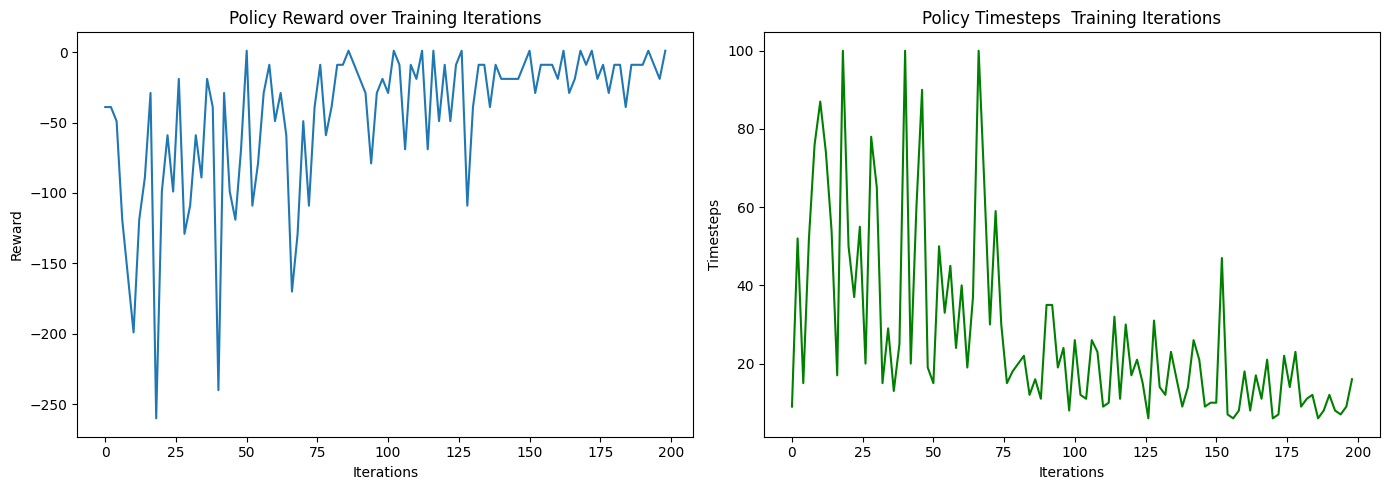

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 5))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(range(0, 200, evaluation_interval), reward_history)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Policy Reward over Training Iterations')

# Plot timesteps
plt.subplot(1, 2, 2)
plt.plot(range(0, 200, evaluation_interval), time_steps_history, color='green')
plt.xlabel('Iterations')
plt.ylabel('Timesteps')
plt.title('Policy Timesteps  Training Iterations')

plt.tight_layout()
plt.show()

## Graphs of Reduced Network

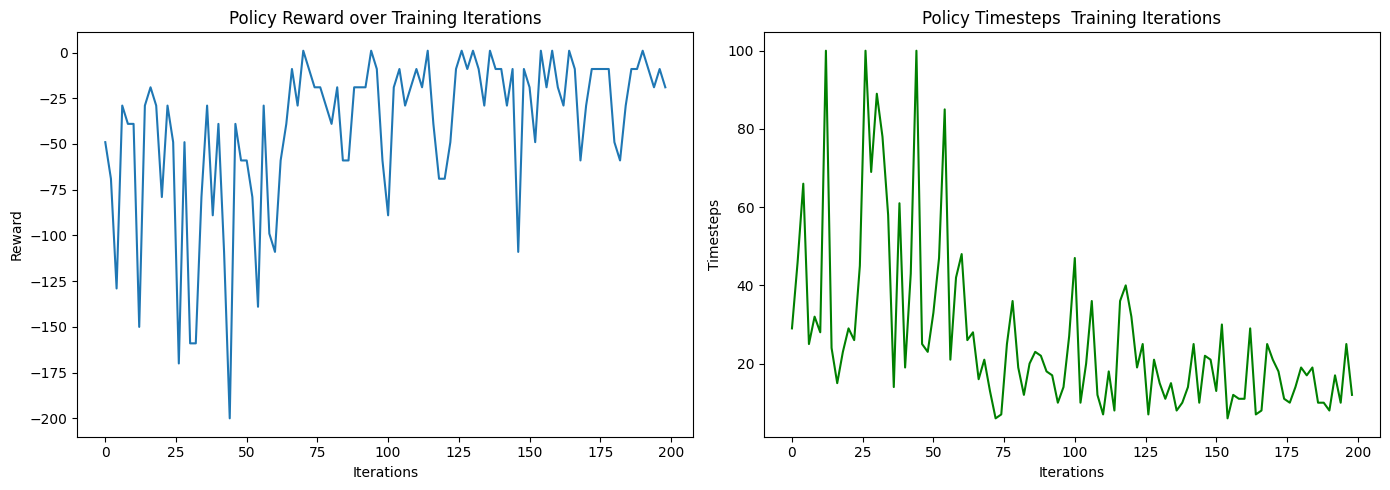

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 5))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(range(0, 200, evaluation_interval), reward_history2)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Policy Reward over Training Iterations')

# Plot timesteps
plt.subplot(1, 2, 2)
plt.plot(range(0, 200, evaluation_interval), time_steps_history2, color='green')
plt.xlabel('Iterations')
plt.ylabel('Timesteps')
plt.title('Policy Timesteps  Training Iterations')

plt.tight_layout()
plt.show()

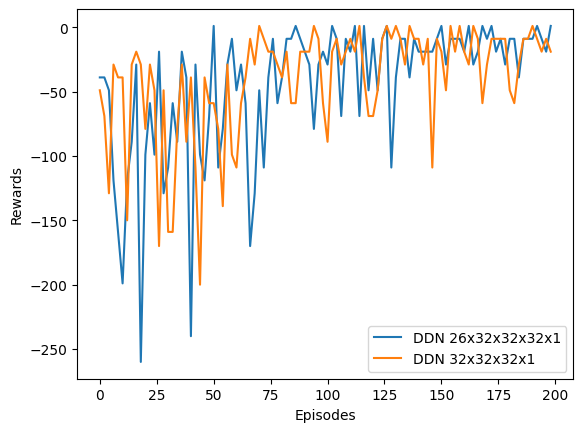

In [ ]:
# Plot the comparison

plt.plot(range(0, 200, evaluation_interval), reward_history, label='DDN 26x32x32x32x1')
plt.plot(range(0, 200, evaluation_interval), reward_history2, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
#plt.title('Deep Dynamic Network vs Feature Extraction Network Performance (With Noise)')
plt.legend()
plt.show()

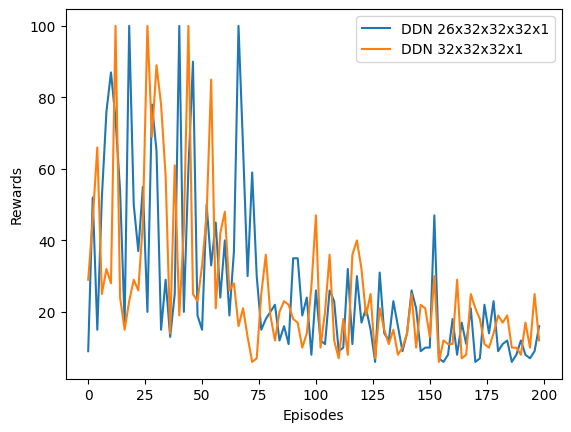

In [ ]:
# Plot the comparison

plt.plot(range(0, 200, evaluation_interval), time_steps_history, label='DDN 26x32x32x32x1')
plt.plot(range(0, 200, evaluation_interval), time_steps_history2, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
#plt.title('Deep Dynamic Network vs Feature Extraction Network Performance (With Noise)')
plt.legend()
plt.show()

# Graphs for Testing

## Original Network

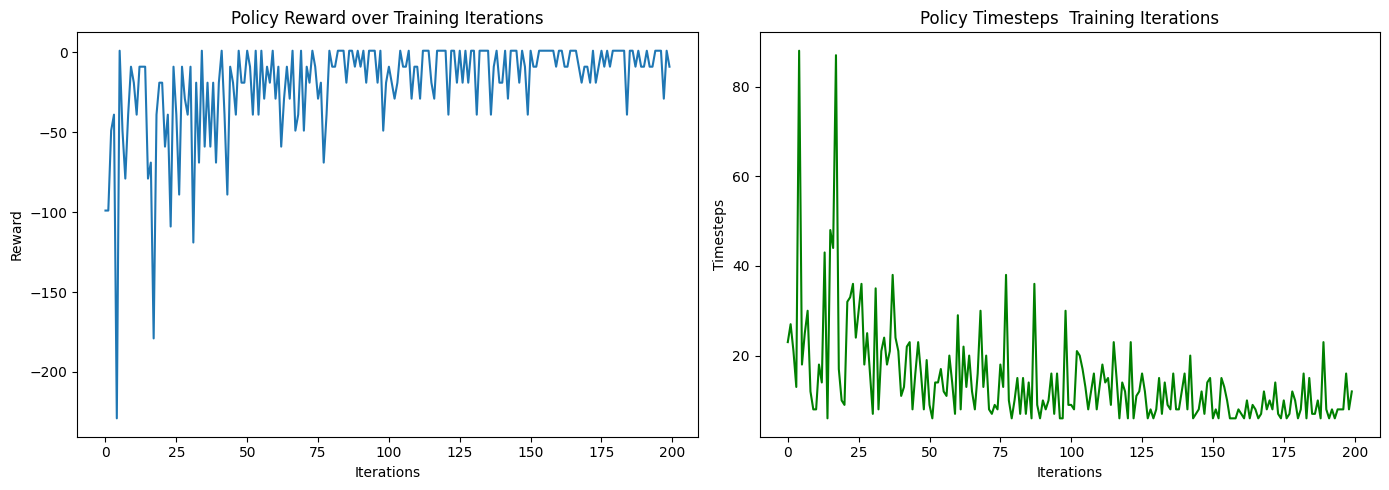

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 5))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(reward_history_test)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Policy Reward over Testing Iterations')

# Plot timesteps
plt.subplot(1, 2, 2)
plt.plot(time_steps_history_test, color='green')
plt.xlabel('Iterations')
plt.ylabel('Timesteps')
plt.title('Policy Timesteps  Testing Iterations')

plt.tight_layout()
plt.show()

## Reduced Network

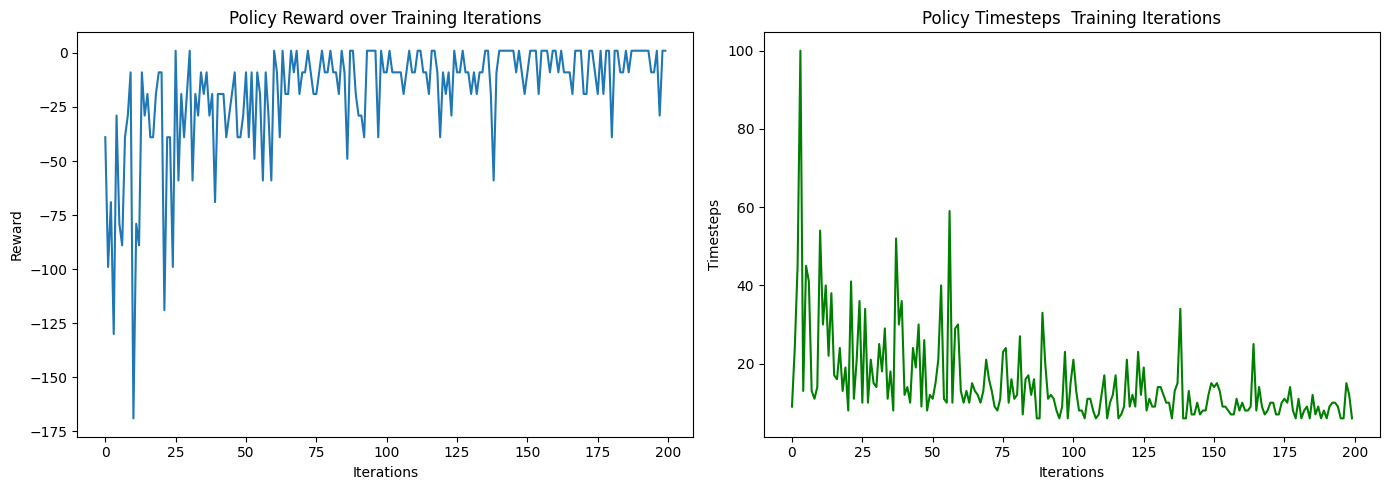

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 5))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(reward_history_test2)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Policy Reward over Testing Iterations')

# Plot timesteps
plt.subplot(1, 2, 2)
plt.plot(time_steps_history_test2, color='green')
plt.xlabel('Iterations')
plt.ylabel('Timesteps')
plt.title('Policy Timesteps  Testing Iterations')

plt.tight_layout()
plt.show()

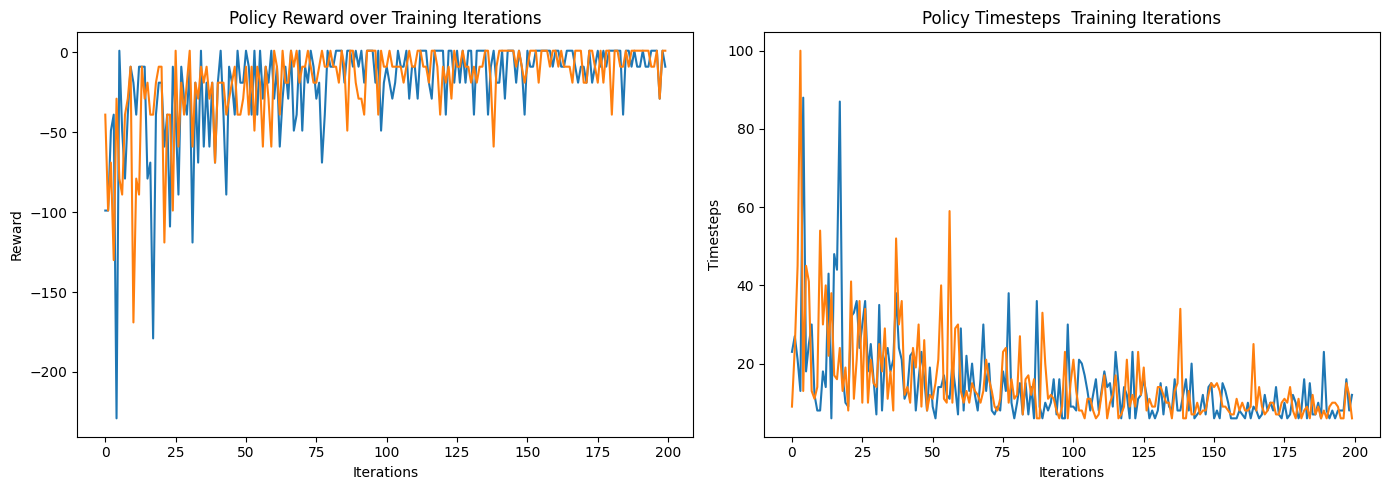

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 5))

# Plot rewards
plt.subplot(1, 2, 1)
plt.plot(reward_history_test, label='DDN 26x32x32x32x1')
plt.plot(reward_history_test2, label='DDN 32x32x32x1')
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title('Policy Reward over Training Iterations')

# Plot timesteps
plt.subplot(1, 2, 2)
plt.plot(time_steps_history_test, label='DDN 26x32x32x32x1')
plt.plot(time_steps_history_test2, label='DDN 32x32x32x1')
plt.xlabel('Iterations')
plt.ylabel('Timesteps')
plt.title('Policy Timesteps  Training Iterations')

plt.tight_layout()
plt.show()